# Training Detector
![img](https://github.com/openvinotoolkit/openvino/assets/71766106/a0e5ac88-28d0-4b01-ac03-6636546b032a)

The first step of reading a meter is obviously detecting it. For this, there are a lot of approaches, and deep learning stands out in all of them. There have been a lot of advances and developments in the deep learning approach of object detection, which makes it pretty efficient and reliable.


There are a lot of object detection models, all of which are unique in themselves, and most of the state-of-the-art models have been covered in TensorFlow's Model Gardern. It is an open-source project that provides all the tools required to build and train a model from scratch in TensorFlow. You can choose from a variety of model architectures available on [TF's model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md#tensorflow-2-detection-model-zoo).


For this usecase, we are going to use EfficientDet-d0, which is an efficient object detection model, and train it with PaddlePaddle's free [meter detection dataset](https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_det.tar.gz).

### Download and Setup
 First we need to clone the TF's model zoo repository and run some test to ensure stable proceedings.

In [ ]:
!git clone https://github.com/tensorflow/models.git

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
#run model builder test
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

### Preparing Dataset
TF's model zoo reqires data to be in TFRecord format which is a simple format for storing a sequence of binary records. It helps to boost the training process as no time will get wasted on loading and processing data at each epoch.

PaddlePaddle dataset includes annotations in JSON format, hence we first converted them to CSV then load them in TFRecord format for training with help of `tfrecord_generator` script.

In [ ]:
import os
import json
import pandas as pd

In [ ]:
# downloading dataset
det = 'https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_det.tar.gz'

if ('meter_seg' not in os.listdir()):
    for i in [det]:
        !wget $i
        dir_name = i.split('/')[-1]
        !tar -xf $dir_name
else:
    print('Directory already exist')

In [ ]:
# converting JSON to CSV
for name in ['test','train']:
    with open(f'meter_det/annotations/instance_{name}.json') as file:
        annotations = json.load(file)

    images = annotations['images']
    annotation = annotations['annotations']

    img_datas = { i['id'] : [i['file_name'][:-4],i['width'],i['height']] for i in images}

    bboxs = {}
    for i in annotation:
        img_id = i['image_id']
        if img_id not in bboxs:
            bboxs[img_id] = [i['bbox']]
        else:
            bboxs[img_id].append(i['bbox'])

    data = []

    for i in list(bboxs.keys()):
        file_name, width, height = img_datas[i]
        for j in bboxs[i]:
            x,y,w,h = j
            values = [file_name+'.jpg',width,height,'meter',x,y,x+w,y+h]
            data.append(values)

    columns = ['filename','width','height','class','xmin','ymin','xmax','ymax']

    df = pd.DataFrame(data,columns=columns)

    df.to_csv(f'meter_det/{name}/{name}_labels.csv',index=None)

In [ ]:
# generating TFRecord from CSVs
!python utils/tfrecord_generator.py --csv_input=meter_det/test/test_labels.csv --image_dir=meter_det/test --output_path=test.record
!python utils/tfrecord_generator.py --csv_input=meter_det/train/train_labels.csv --image_dir=meter_det/train --output_path=train.record

### Downlaoding model and setting configs
First, we download the model artitecture in TF's checkpoint(.ckpt) format from the model zoo.

To train a model with TF's model repository we need a config file which include all the information/parameters required for training the model like Optimizers, Losses, Regulizers, Depth, activation function etc. We can make changes in this config file to train model in our way.

Other than config file we will need a `labelmap.pbtxt` which contain class name and class index.

And after training model with `model_main_tf2.py` we will export the trained model with `exporter_main_v2.py`

In [ ]:
#downloading model artitechture
model_link = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz'
!wget {model_link}
!tar -xf efficientdet_d0_coco17_tpu-32.tar.gz

In [ ]:
#creating labelmap.pbtxt
labelmap = "item {\n\tid : 1 \n\tname : 'meter'\n}"
with open('labelmap.pbtxt','w') as f:
    f.writelines(labelmap)

In [ ]:
batch_size = 4
num_steps = 8000
num_eval_steps = 1000

base_config_file = 'models/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config'
custom_config_file = 'efficientdet.config'
labelmap_path = 'labelmap.pbtxt'
fine_tune_checkpoint = 'efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0'
train_record_path = 'train.record'
test_record_path = 'test.record'

In [ ]:
import re

with open(base_config_file) as f:
    config = f.read()

with open(custom_config_file, 'w') as f:
  
  # Set labelmap path
  config = re.sub('label_map_path: ".*?"', 
             'label_map_path: "{}"'.format(labelmap_path), config)
  
  # Set fine_tune_checkpoint path
  config = re.sub('fine_tune_checkpoint: ".*?"',
                  'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), config)
  
  # Set train tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 
                  'input_path: "{}"'.format(train_record_path), config)
  
  # Set test tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 
                  'input_path: "{}"'.format(test_record_path), config)
  
  # Set number of classes.
  config = re.sub('num_classes: [0-9]+',
                  'num_classes: {}'.format(1), config)
  
  # Set batch size
  config = re.sub('batch_size: [0-9]+',
                  'batch_size: {}'.format(batch_size), config)
  
  # Set training steps
  config = re.sub('num_steps: [0-9]+',
                  'num_steps: {}'.format(num_steps), config)
  
  # Set required BBOXs
  config = re.sub('max_total_detections: [0-9]+',
                  'max_total_detections: {}'.format(10), config)
  
  # # Set required BBOXs per class
  config = re.sub('max_detections_per_class: [0-9]+',
                  'max_detections_per_class: {}'.format(10), config)
  
  # Set fine-tune checkpoint type to detection
  config = re.sub('fine_tune_checkpoint_type: "classification"', 
             'fine_tune_checkpoint_type: "{}"'.format('detection'), config)
  
  f.write(config)

In [ ]:
model_dir = 'training/'
pipeline_config_path = 'efficientdet.config'

In [ ]:
# Training the model
!python models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

In [ ]:
# Exporting the trained model
output_directory = 'inference_graph'

!python models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {model_dir} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_config_path}

In [ ]:
!zip -r saved_model.zip inference_graph/saved_model

### Inference with trained model

Once we got the trained model in TF's SavedModel format now we can perform inference and verify result

In [ ]:
import tensorflow as tf
import cv2 
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
detector = tf.saved_model.load('inference_graph/saved_model')

In [ ]:
img = cv2.imread('/content/meter_det/test/20190822_86.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [ ]:
detection = detector(img.reshape(1,1080,1920,3))

In [ ]:
bbox_r = detection['detection_boxes'].numpy()
bbox = np.multiply(bbox_r,np.array([1080,1920,1080,1920])).astype(np.int64)

In [ ]:
y,x,yy,xx = bbox[0][0]
i = cv2.rectangle(img,(x,y),(xx,yy),(255,0,0),3)

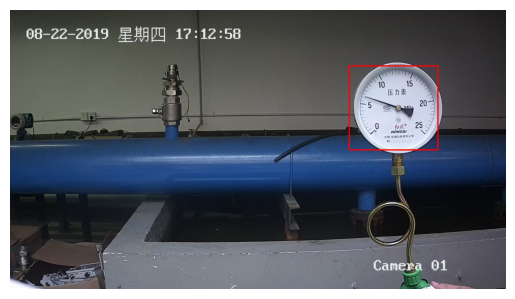

In [ ]:
plt.imshow(i);plt.axis(False);plt.show()